# Effect of supplementary PID cuts

In [1]:
%reset -f

import ROOT, numpy

ROOT.gErrorIgnoreLevel = ROOT.kWarning

ROOT.gStyle.SetOptFit(1)
ROOT.gStyle.SetOptStat(0)

ROOT.gStyle.SetGridColor(17)
ROOT.gStyle.SetPadGridX(1)
ROOT.gStyle.SetPadGridY(1)

ROOT.gStyle.SetPadRightMargin(0.01)
ROOT.gStyle.SetPadLeftMargin(0.075)
ROOT.gStyle.SetPadBottomMargin(0.12)

ROOT.gStyle.SetTitleFont(42,'xy')
ROOT.gStyle.SetTitleFont(42,'T')
ROOT.gStyle.SetTitleSize(0.075, 'XY')
ROOT.gStyle.SetTitleSize(0.1, 'T')
ROOT.gStyle.SetTitleOffset(0.8, 'X')
ROOT.gStyle.SetTitleOffset(0.58, 'Y')
ROOT.gStyle.SetLabelFont(42,'xy')
ROOT.gStyle.SetLabelSize(0.07, 'XY')

ROOT.gStyle.SetMarkerSize(2)
ROOT.TH1.AddDirectory(0)

%run -i eppi0_columns.py
%run -i eppi0_binning_scheme_v3.py
%run -i load_data.py
%run -i eppi0_bsa.py


dfs = []
#for fname in ["data/lvl2_eppi0.inb.qa.ecorr.pcorr.root", "data/lvl2_eppi0.outb.qa.ecorr.pcorr.root"]:
#    for ist in [0,1]:
#        df = load_rdf(f"{fname}.{ist}.root")
#        dfs.append(df)


for fname in ["data/lvl2_eppi0.inb.qa.ecorr.pcorr.root", "data/lvl2_eppi0.outb.qa.ecorr.pcorr.root"]:
#    break
    df = ROOT.RDataFrame("h22", fname)
    df = define_eppi0_columns_using_proton(df)
    df = df.Filter("abs(dpx)<0.3 && abs(dpy)<0.3 && abs(dphi)<4 && dpz>-0.5 && dpz<0.9 && mm2>-0.3 && mm2<0.4")
    for status in ["true", " && ".join(f"(((int)status)&(1<<{i}))" for i in [ecloose,prodc])]:                                                                                                           
        rdf = df.Filter(status)
        rdf = define_eppi0_bins(rdf, fname)
        dfs.append(rdf)

rdfs = [] 
for rdf in dfs:
    make_allbsas(rdf)

    rdfs.append(rdf)


Welcome to JupyROOT 6.24/06


In [2]:
def xshift(gr0, dx=0):
    for i in range(gr0.GetN()):
        gr0.SetPointX(i, gr0.GetPointX(i)+dx)
    return gr0

------------------------
------------------------
------------------------

#### $A_{LU}$ vs $-t$ for each $\{Q^2,x_B\}$ bin

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


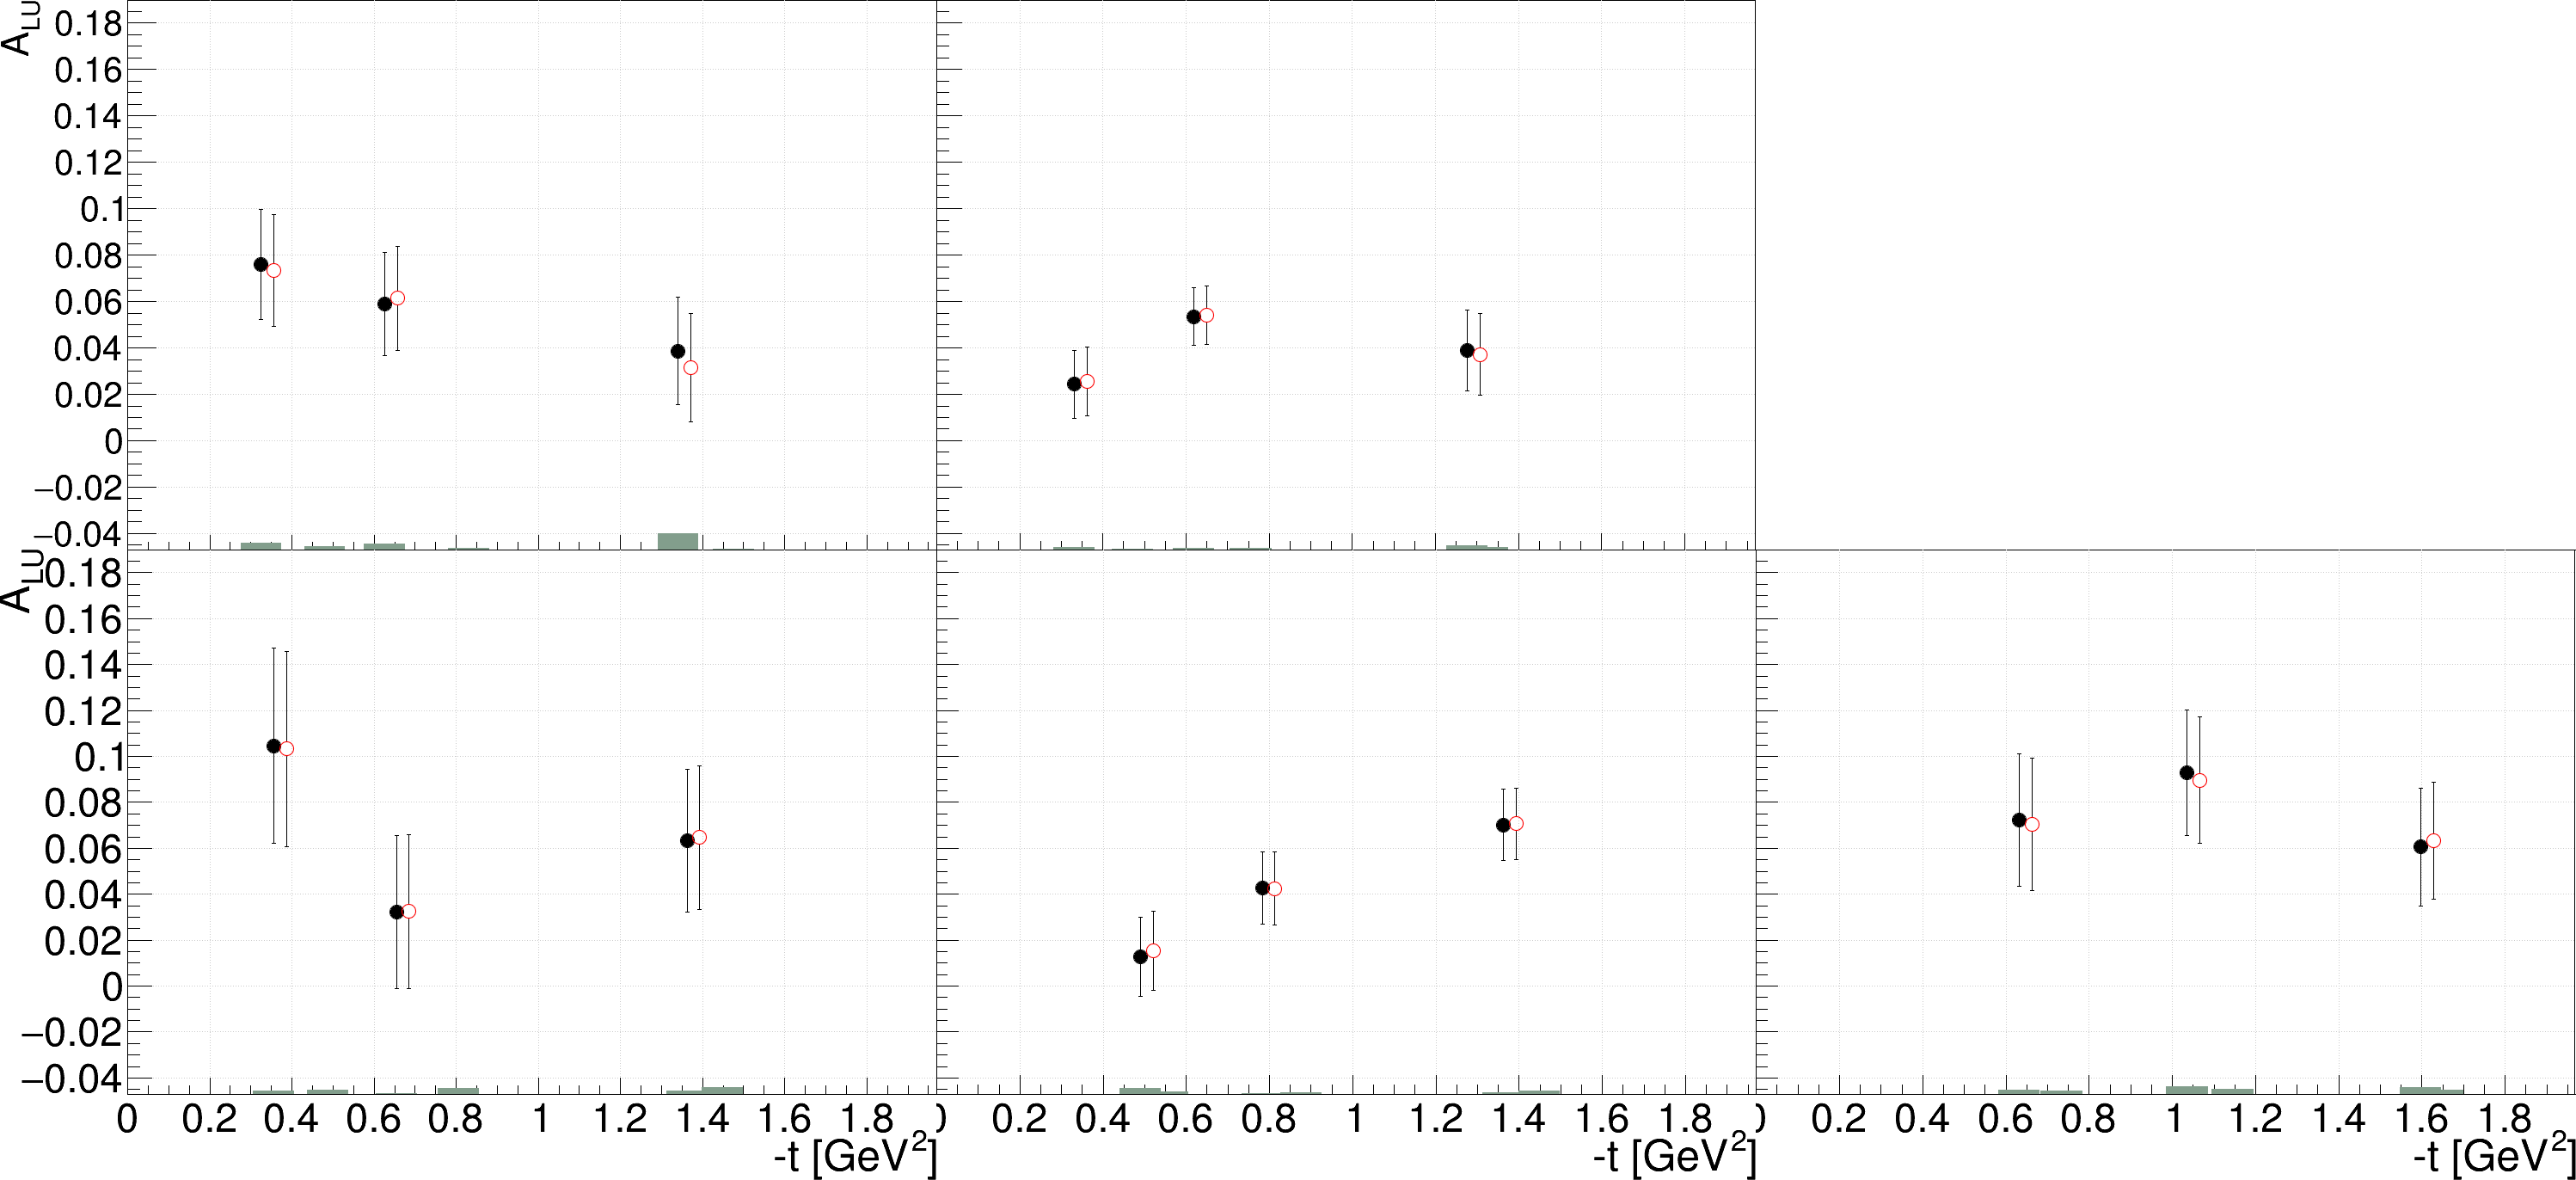

In [3]:
ROOT.gStyle.SetTitleOffset(0.96, 'Y')
ROOT.gStyle.SetPadLeftMargin(0.12)

httdfid = ROOT.TH1F("httfid","fiducial cuts systematics;#Delta_{syst}",200,0,0.052)

adf,adf1,bdf,bdf1 = rdfs

c1 = ROOT.TCanvas("c1","c1",3000,1400)
c1.Draw()
c1.SetTopMargin(0)
c1.SetRightMargin(0)
c1.Divide(3,2,0,0)

grs = []

ipad=0
for aqdf in adf.qdfs:
    bid = aqdf.binid
    bqdf = bdf.shards[bid]
    aqdf1 = adf1.shards[bid]
    bqdf1 = bdf1.shards[bid]

    ipad += 2 if ipad==2 else 1
    if ipad==2: c1.cd(ipad).SetRightMargin(0.001)

    h1 = c1.cd(ipad).DrawFrame(0,-0.047,1.97,0.19)
    h1.SetTitle(";-t [GeV^{2}];A_{LU}");

    grsys = ROOT.TGraphErrors()
    gr0, gr1 = aqdf.grp1.Clone(), bqdf.grp1.Clone()
    gr2, gr3 = xshift(aqdf1.grp1.Clone(),0.03), xshift(bqdf1.grp1.Clone(), 0.03)
    
    for i in range(3):
        httdfid.Fill(abs(gr0.GetPointY(i)-gr2.GetPointY(i)))
        httdfid.Fill(abs(gr1.GetPointY(i)-gr3.GetPointY(i)))
        grsys.SetPoint(grsys.GetN(), gr0.GetPointX(i), -0.047)
        grsys.SetPointError(grsys.GetN()-1, 0.05, abs(gr0.GetPointY(i)-gr2.GetPointY(i)))
        grsys.SetPoint(grsys.GetN(), gr1.GetPointX(i), -0.047)
        grsys.SetPointError(grsys.GetN()-1, 0.05, abs(gr1.GetPointY(i)-gr3.GetPointY(i)))

    gr0.Draw("P")
    #gr1.Draw("P")

    gr2.Draw("P")
    #gr3.Draw("P")

    gr0.SetMarkerStyle(20)
    gr1.SetMarkerStyle(21)
    gr2.SetMarkerStyle(24)
    gr3.SetMarkerStyle(25)
    gr2.SetMarkerColor(2)
    gr3.SetMarkerColor(2)
    
    grsys.SetFillColor(32)
    grsys.Draw("2")
    grs.append(grsys)


------------------------
------------------------

#### BSA graphs for each $\{Q^2,x_B,-t\}$ bin

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


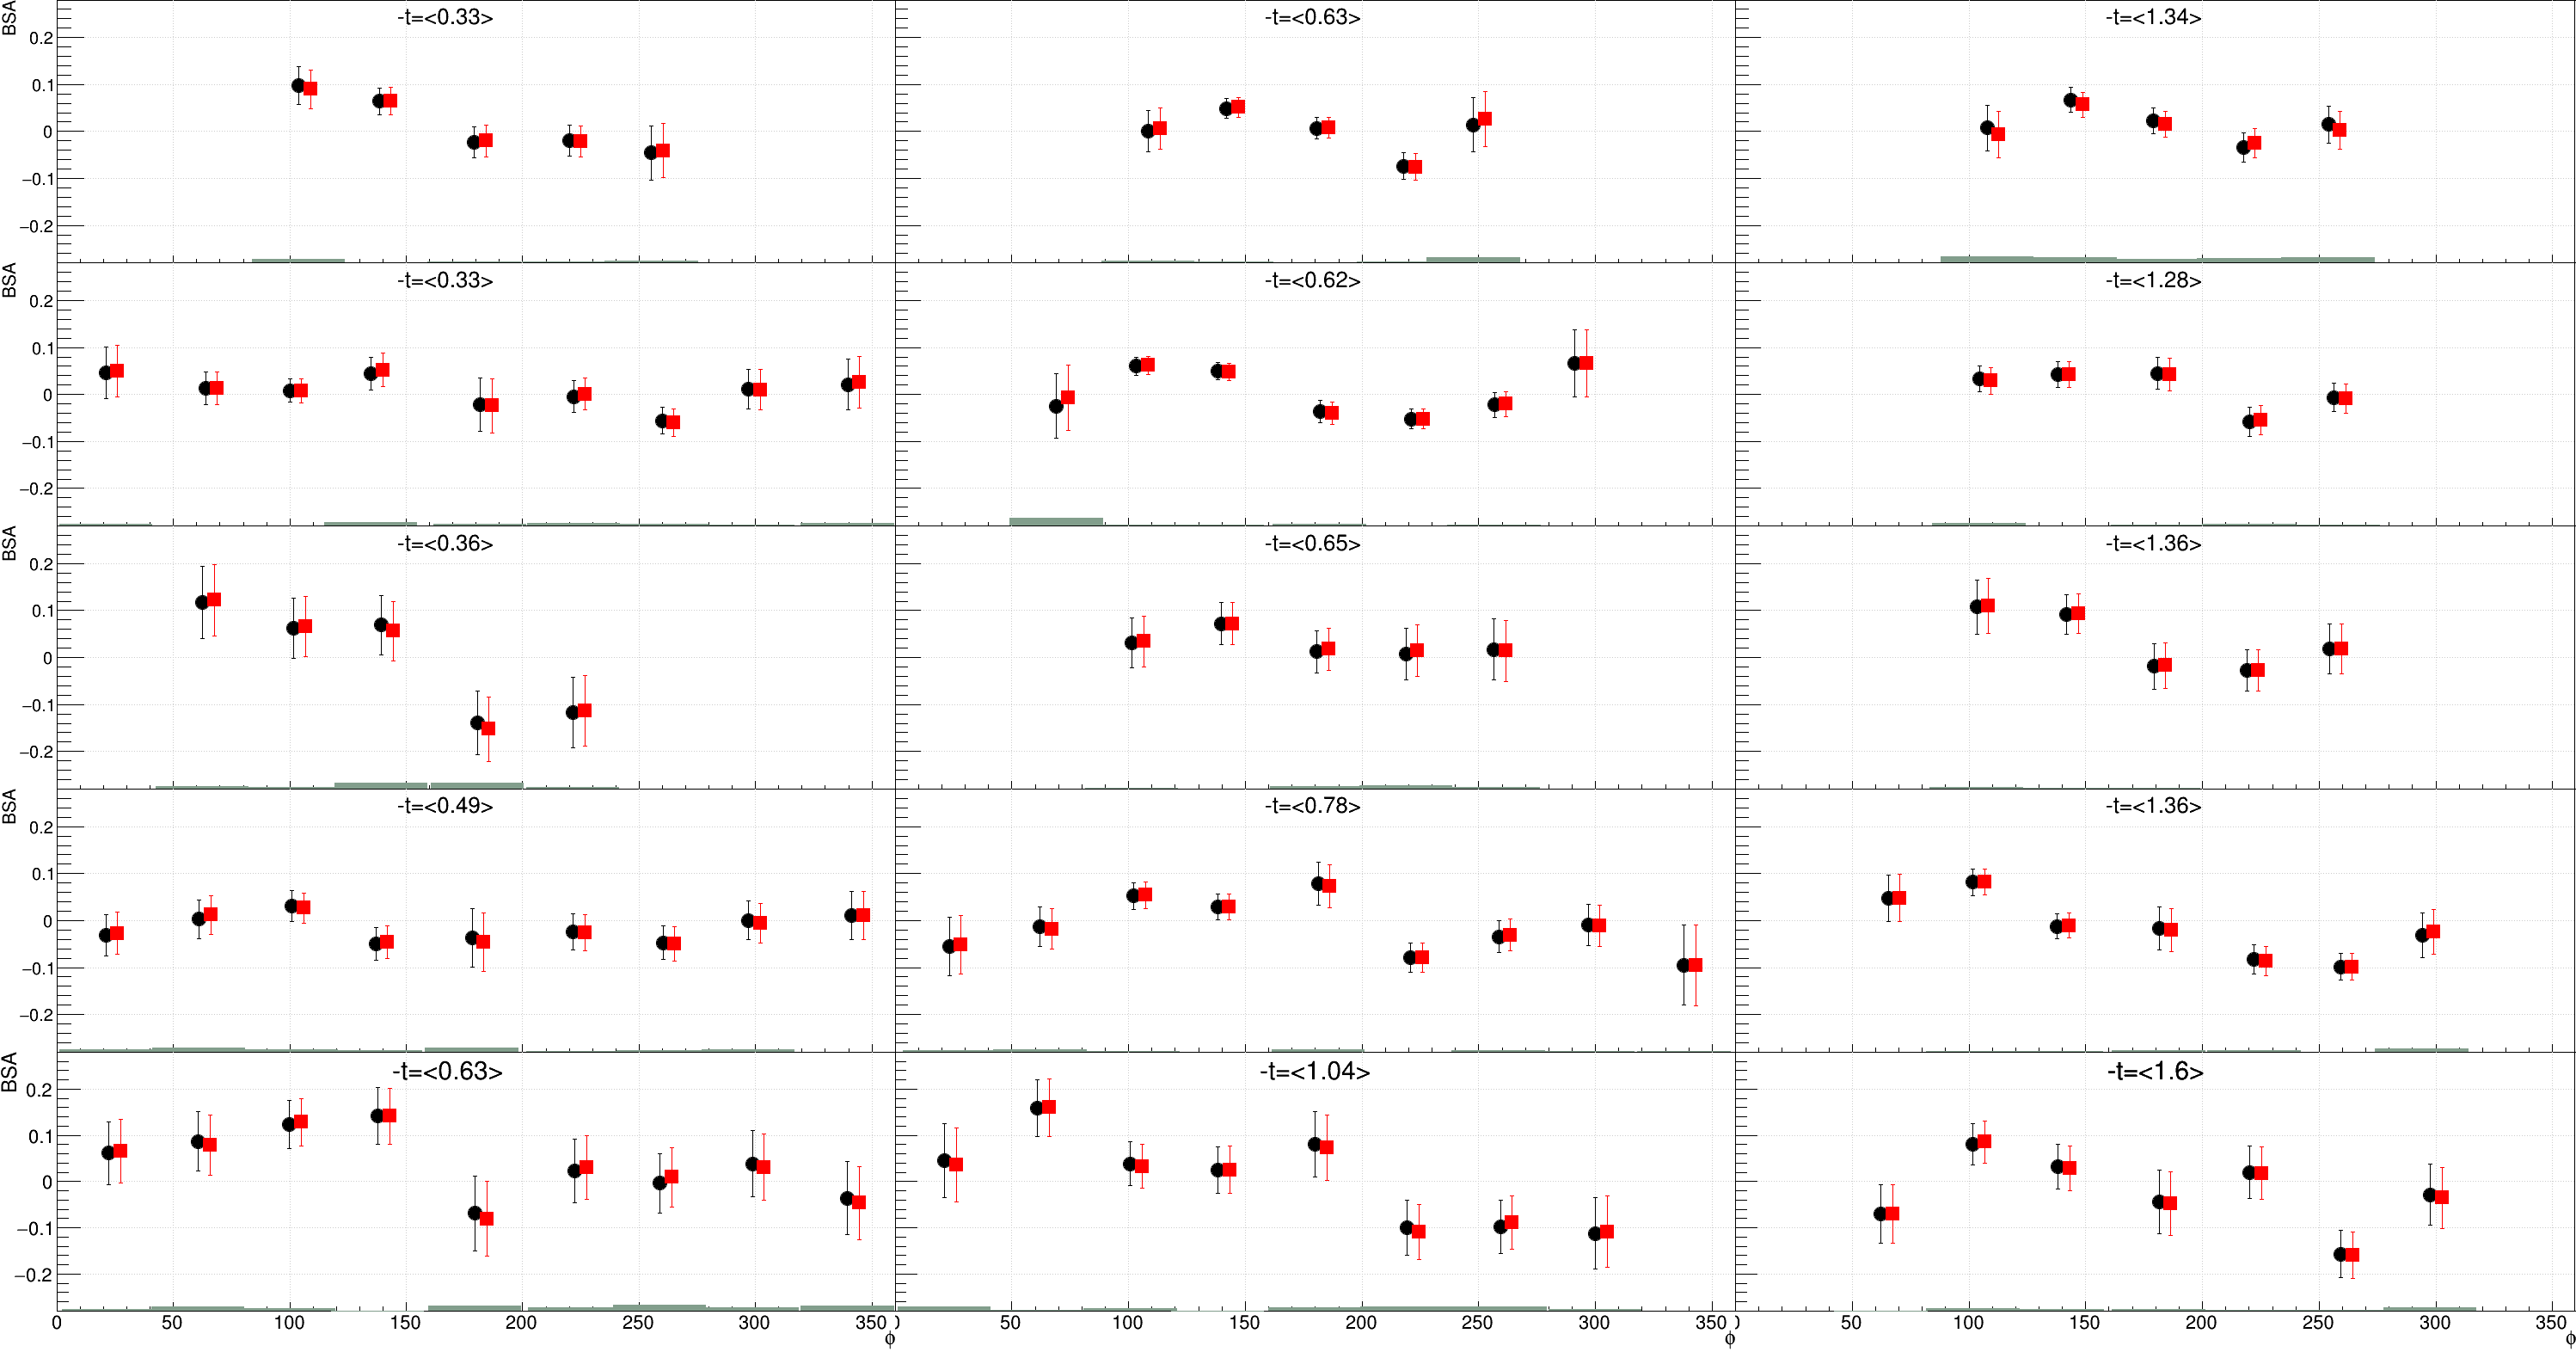

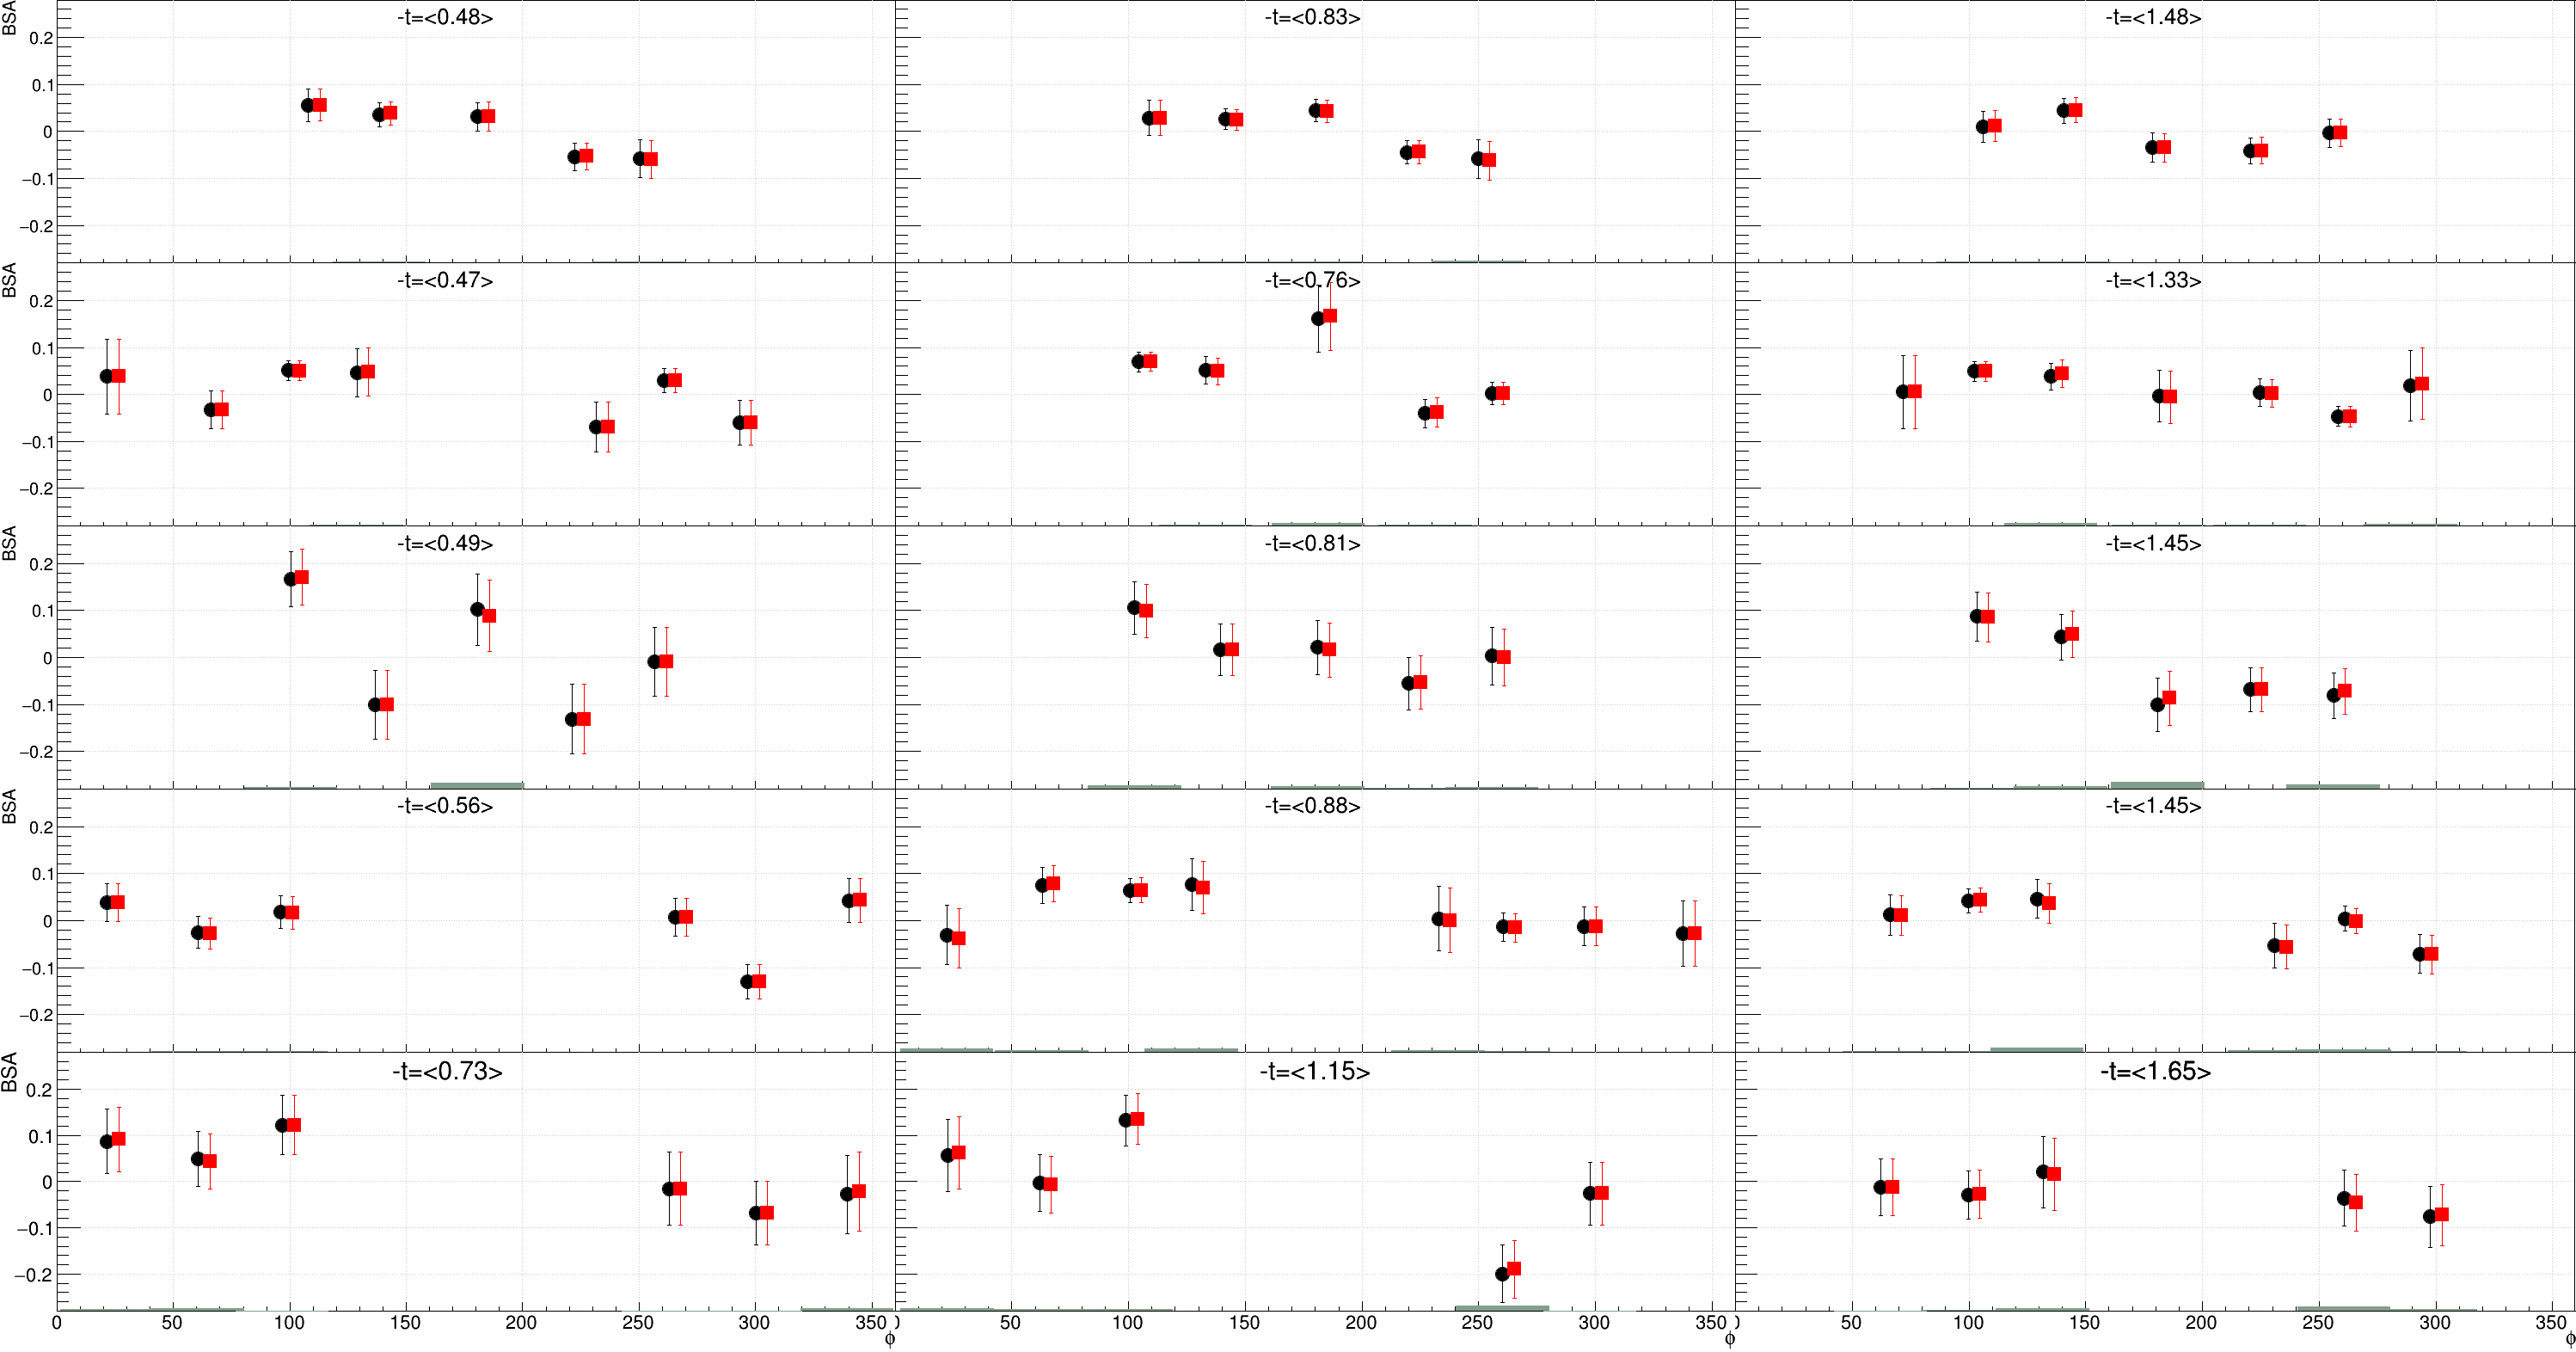

In [4]:
ROOT.gStyle.SetTitleOffset(0.45, 'Y')
ROOT.gStyle.SetPadLeftMargin(0.06)

hfidfid = ROOT.TH1F("hfifid","fiducial cuts systematics;#Delta_{syst}",200,0,0.112)

idf,idf1,odf,odf1 = rdfs

c1 = ROOT.TCanvas("c1","c1",3000,1600)
c1.Draw()
c1.SetTopMargin(0)
c1.SetRightMargin(0)
c1.Divide(3,5,0,0)

fibins = range(0,361,40)
grs = []

ipad=0
for qdf in idf.qdfs:
    for tdf in qdf.tdfs:
        ipad+=1
        bid = tdf.binid
        itdf1 = idf1.shards[bid]

        h1 = c1.cd(ipad).DrawFrame(0,-0.28,360,0.28)
        h1.SetTitle(f"-t=<{round(tdf.tt,2)}>;#phi;BSA")

        grsys = ROOT.TGraphErrors()
        gr0, gr1 = tdf.grbsa.Clone(), xshift(itdf1.grbsa.Clone(), 5)
        y1s = {numpy.digitize(gr1.GetPointX(i), fibins):gr1.GetPointY(i) for i in range(gr1.GetN())}
        for i in range(gr0.GetN()):
            kk = numpy.digitize(gr0.GetPointX(i), fibins)
            if kk in y1s:
                y1 = y1s[kk]
                hfidfid.Fill(abs(gr0.GetPointY(i)-y1))
                grsys.SetPoint(grsys.GetN(), gr0.GetPointX(i), -0.28)
                grsys.SetPointError(grsys.GetN()-1, 20, abs(gr0.GetPointY(i)-y1))

        gr0.Draw("P")
        gr1.Draw("P")
        
        gr0.SetMarkerStyle(20)
        gr1.SetMarkerStyle(21)
        gr1.SetMarkerColor(2)
        gr1.SetLineColor(2)

        grsys.SetFillColor(32)
        grsys.Draw("2")
        grs.append(grsys)
        
c2 = ROOT.TCanvas("c2","c2",3000,1600)
c2.Draw()
c2.SetTopMargin(0)
c2.SetRightMargin(0)
c2.Divide(3,5,0,0)
ipad=0
for qdf in odf.qdfs:
    for tdf in qdf.tdfs:
        ipad+=1
        bid = tdf.binid
        otdf1 = odf1.shards[bid]

        h1 = c2.cd(ipad).DrawFrame(0,-0.28,360,0.28)
        h1.SetTitle(f"-t=<{round(tdf.tt,2)}>;#phi;BSA")

        grsys = ROOT.TGraphErrors()
        gr0, gr1 = tdf.grbsa.Clone(), xshift(otdf1.grbsa.Clone(), 5)
        y1s = {numpy.digitize(gr1.GetPointX(i), fibins):gr1.GetPointY(i) for i in range(gr1.GetN())}
        for i in range(gr0.GetN()):
            kk = numpy.digitize(gr0.GetPointX(i), fibins)
            if kk in y1s:
                y1 = y1s[kk]
                hfidfid.Fill(abs(gr0.GetPointY(i)-y1))
                grsys.SetPoint(grsys.GetN(), gr0.GetPointX(i), -0.28)
                grsys.SetPointError(grsys.GetN()-1, 20, abs(gr0.GetPointY(i)-y1))
        
        gr0.Draw("P")
        gr1.Draw("P")
        
        gr0.SetMarkerStyle(20)
        gr1.SetMarkerStyle(21)
        gr1.SetMarkerColor(2)
        gr1.SetLineColor(2)

        grsys.SetFillColor(32)
        grsys.Draw("2")
        grs.append(grsys)
        


### 1D distributions

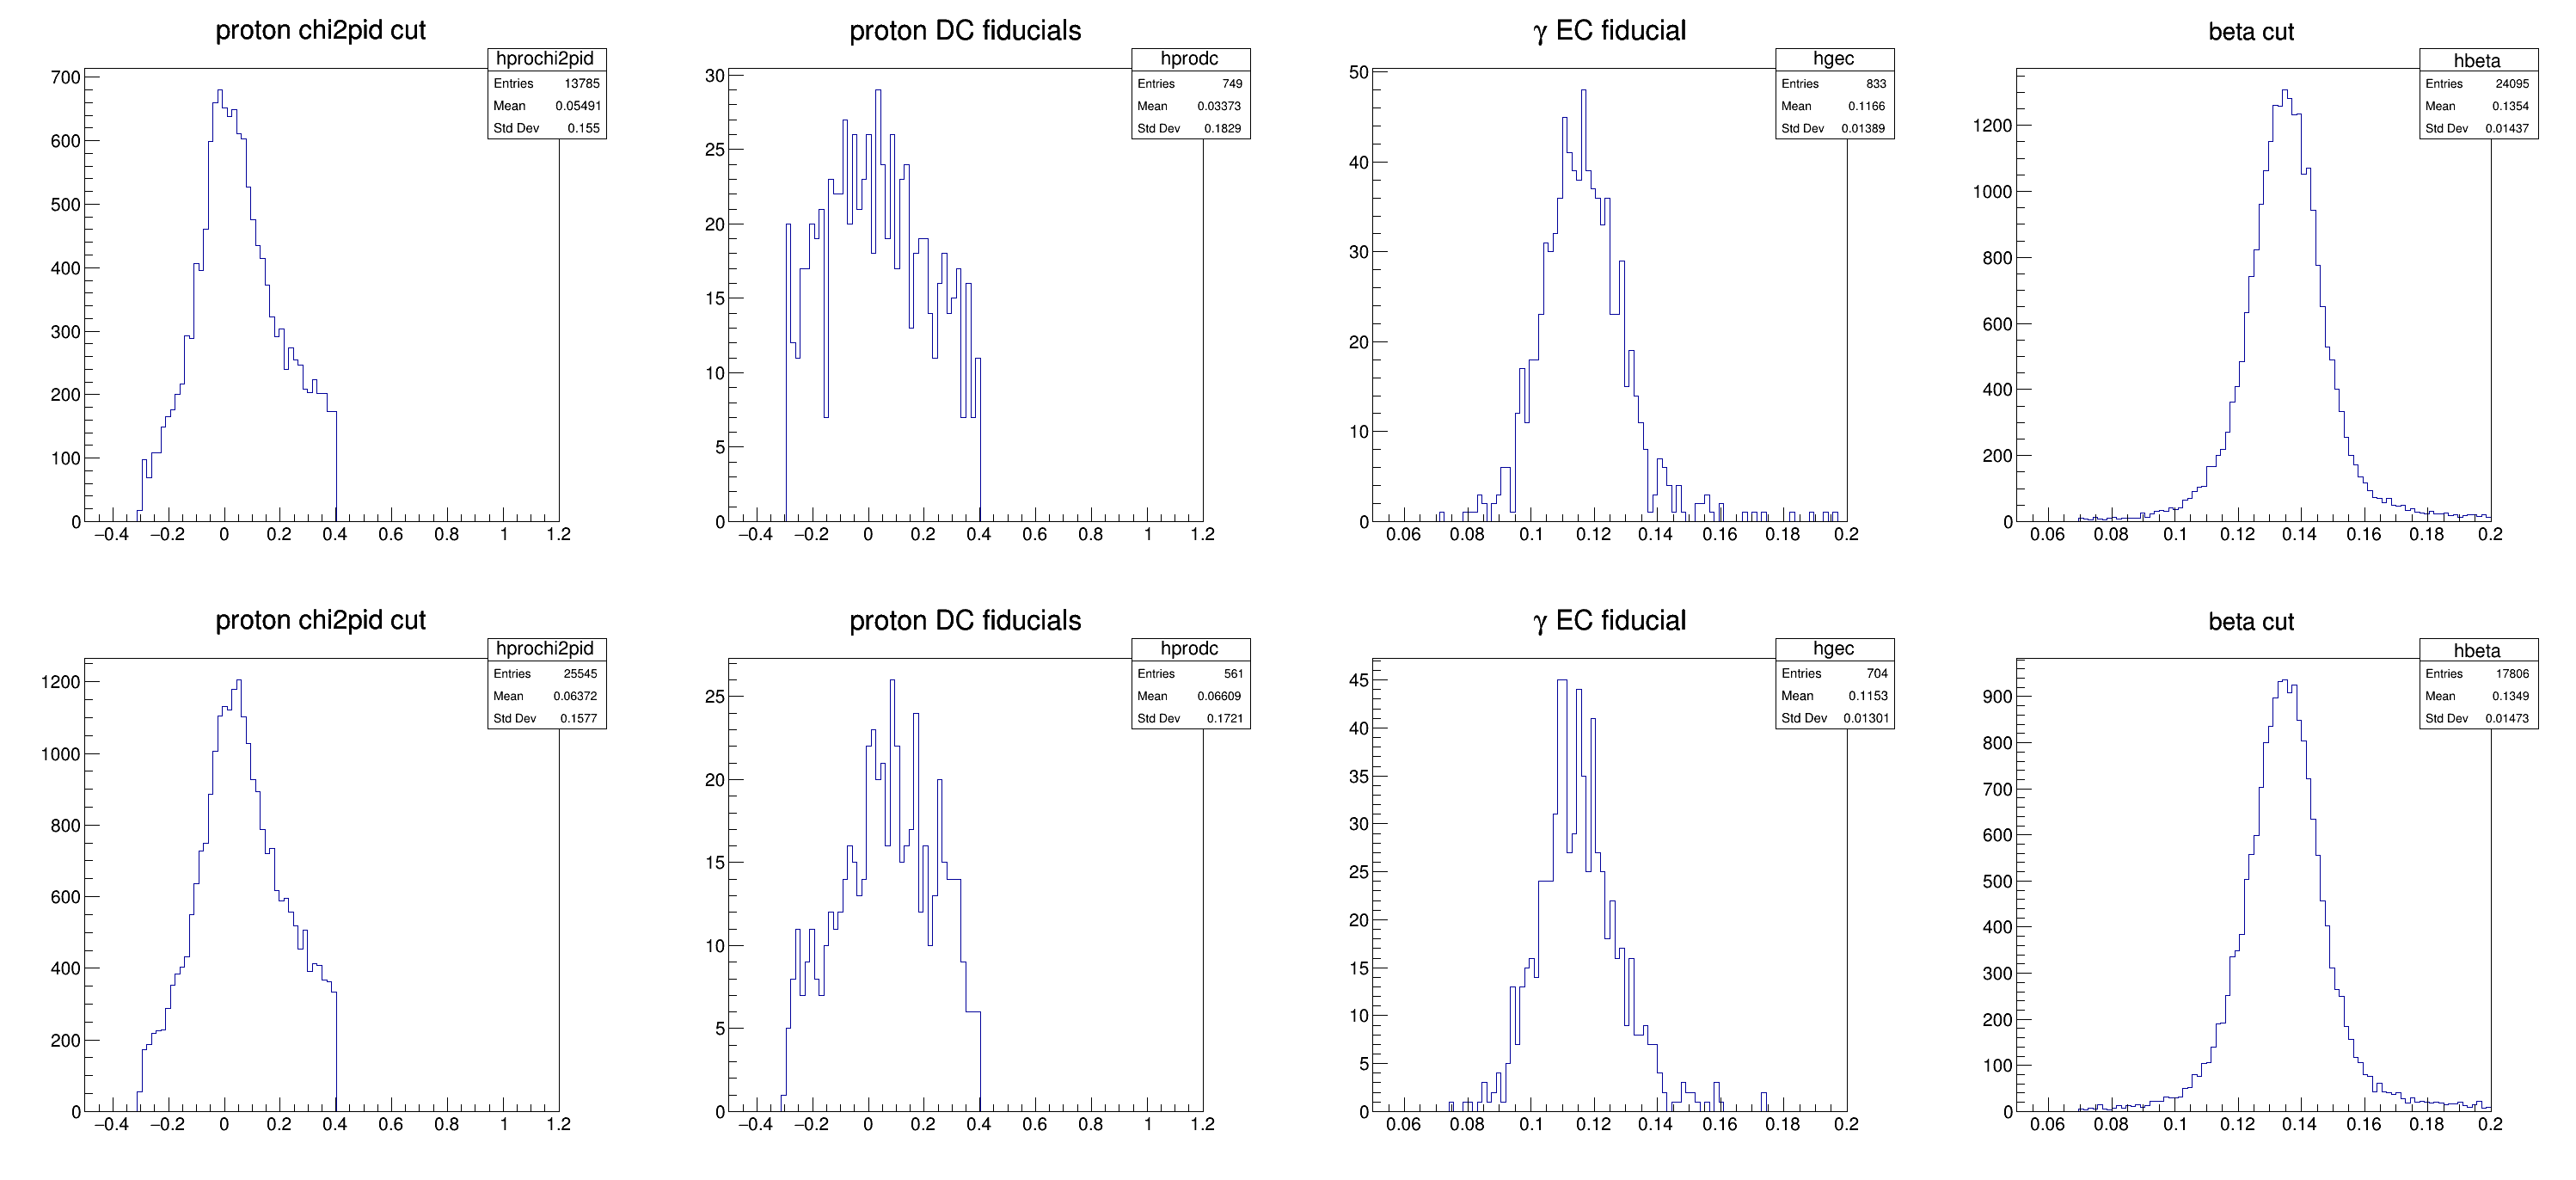

In [2]:
%reset -f

import ROOT

%run -i eppi0_columns.py

c1 = ROOT.TCanvas("c1","c1",3000,1400)
c1.Divide(4,2)
c1.Draw()

ROOT.gStyle.SetOptStat(1)

h1s=[]
ipad = 0
for fname in ["data/lvl2_eppi0.inb.qa.ecorr.pcorr.root", "data/lvl2_eppi0.outb.qa.ecorr.pcorr.root"]:
#for fname in ["data/lvl2_eppi0.outb.qa.ecorr.pcorr.root"]:
    df = ROOT.RDataFrame("h22", fname)
    df = define_eppi0_columns_using_proton(df)
    df = df.Filter("abs(dpx)<0.3 && abs(dpy)<0.3 && abs(dphi)<4 && dpz>-0.5 && dpz<0.9 && mm2>-0.3 && mm2<0.4")
    
    h1 = df.Filter(f"!(((int)status) & (1<<{prochi2}))").Histo1D(("hprochi2pid","proton chi2pid cut",100,-0.5,1.2), "mm2")
    h2 = df.Filter(f"!(((int)status) & (1<<{prodc}))").Histo1D(("hprodc","proton DC fiducials",100,-0.5,1.2), "mm2")
    
    h3 = df.Filter(f"!(((int)status) & (1<<{gloosest}))").Histo1D(("hgec","#gamma EC fiducial",100,0.05,0.2), "mgg")
    h4 = df.Filter(f"!(((int)status) & (1<<{gbeta}))").Histo1D(("hbeta","beta cut",100,0.05,0.2), "mgg")

    #h1 = df.Filter("thp>44.106+-6.625*pp+1.438*pp*pp").Histo1D(("hpropth","proton p vs #theta cut",100,-0.5,1.2), "mm2")
    #h2 = df.Filter("thp<44.106+-6.625*pp+1.438*pp*pp").Filter(f"!(((int)status) & (1<<{prodc}))").Histo1D(("hprodc","proton DC fiducials",100,-0.5,1.2), "mm2")
    
    h1s.extend([h1,h2,h3,h4])
    
    for hh in h1s[-1]:
        ipad+=1
        c1.cd(ipad)
        hh.Draw()


________________________________

________________________________

________________________________

# $M_{\gamma\gamma}$ vs V and W in EC

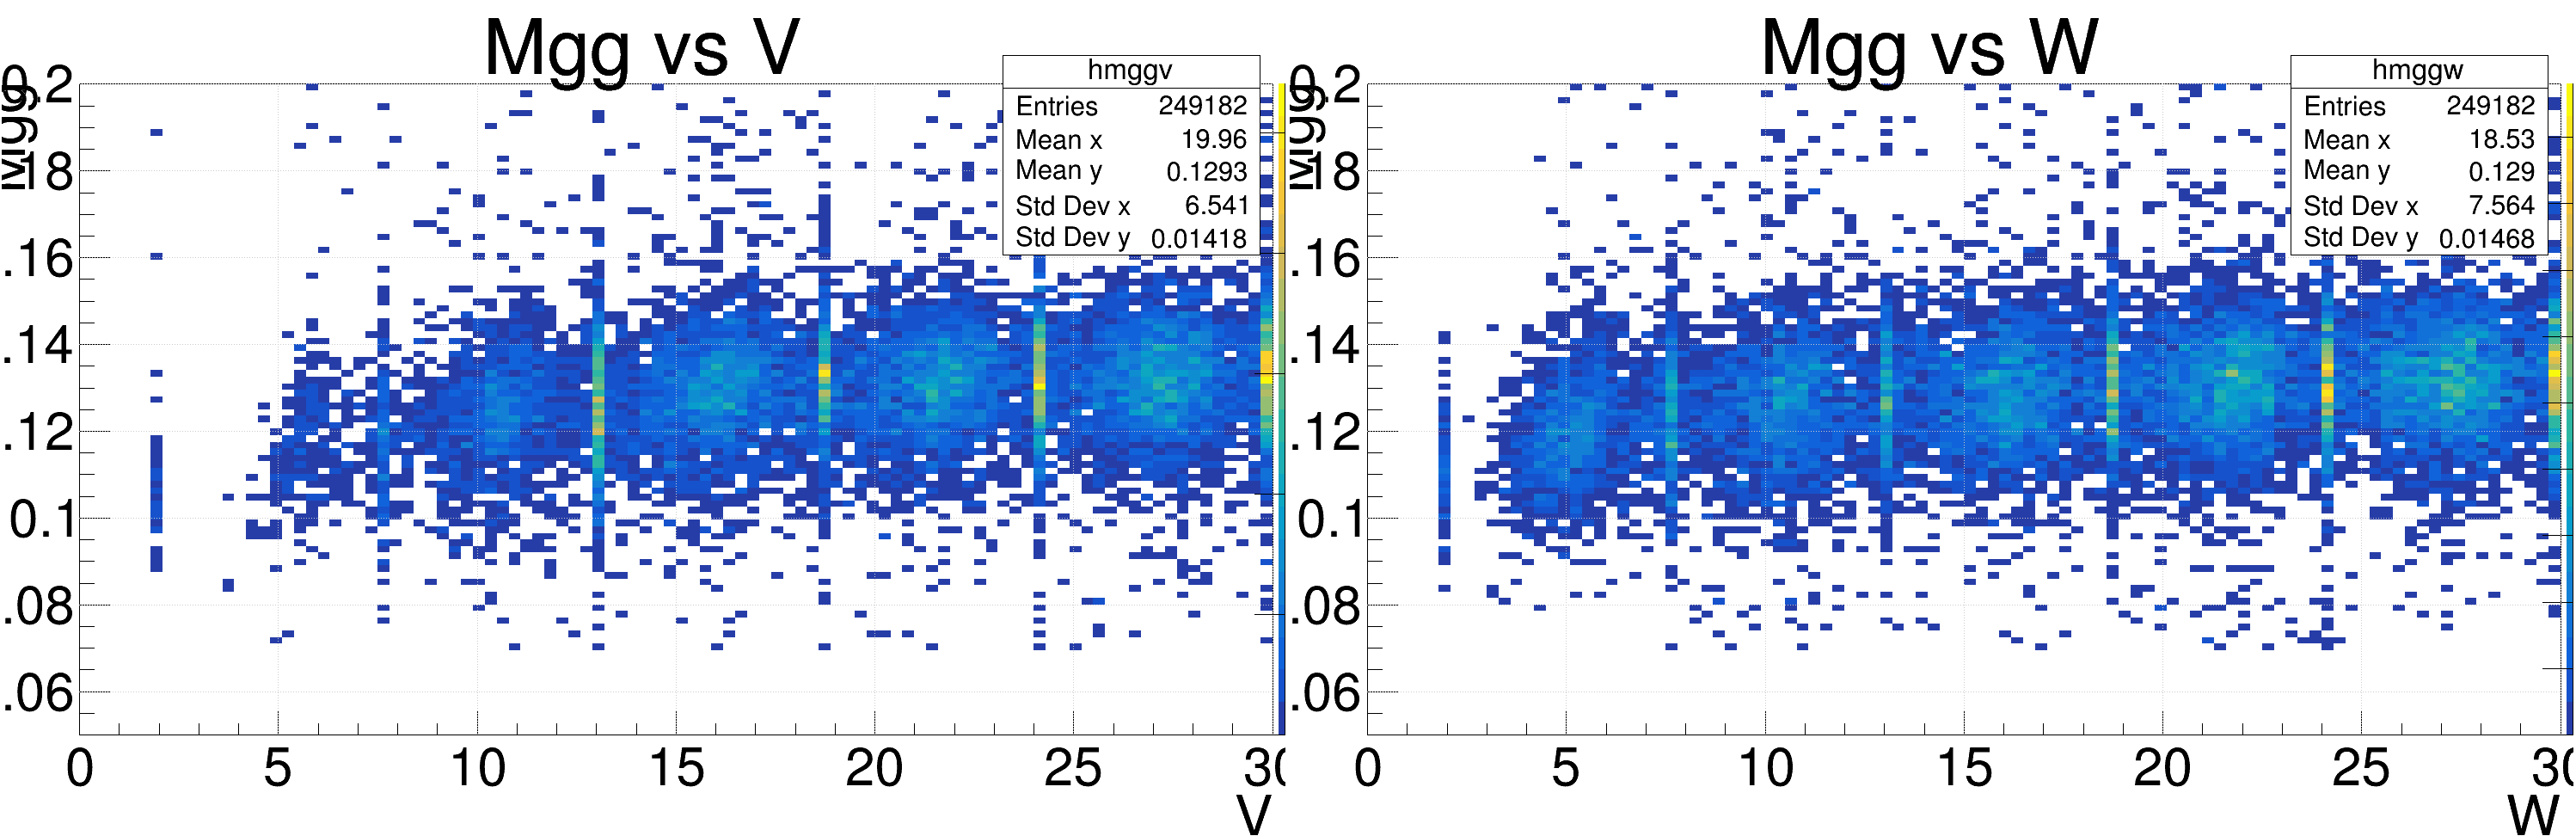

In [6]:
%reset -f

import ROOT

ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetGridColor(17)
ROOT.gStyle.SetPadGridX(1)
ROOT.gStyle.SetPadGridY(1)

%run -i eppi0_columns.py

c1 = ROOT.TCanvas("c1","c1",3000,1000)
c1.Divide(2,1,0.001,0.001)
c1.Draw()

ROOT.gStyle.SetOptStat(1)


h1s=[]
#for fname in ["data/lvl2_eppi0.inb.qa.ecorr.pcorr.root", "data/lvl2_eppi0.outb.qa.ecorr.pcorr.root"]:
for fname in ["data/lvl2_eppi0.inb.qa.ecorr.pcorr.root"]:
    df = ROOT.RDataFrame("h22", fname)
    df = define_eppi0_columns_using_proton(df)
    df = df.Filter("abs(dpx)<0.3 && abs(dpy)<0.3 && abs(dphi)<4 && dpz>-0.5 && dpz<0.9 && mm2>-0.3 && mm2<0.4")

    h51 = df.Histo2D(("hmggv","Mgg vs V;V;Mgg",100,0,30,100,0.05,0.2), "g1v", "mgg")
    h61 = df.Histo2D(("hmggw","Mgg vs W;W;Mgg",100,0,30,100,0.05,0.2), "g1w", "mgg")
    h52 = df.Histo2D(("hmggv","Mgg vs V",100,0,30,100,0.05,0.2), "g2v", "mgg")
    h62 = df.Histo2D(("hmggw","Mgg vs W",100,0,30,100,0.05,0.2), "g2w", "mgg")
    
    c1.cd(1)
    h51.Add(h52.GetValue())
    h51.Draw("colz")
    
    c1.cd(2)
    h61.Add(h62.GetValue())
    h61.Draw("colz")

________________________________

________________________________

________________________________

# Pt vs Px/Py

In [8]:
%reset -f

import ROOT, numpy

ROOT.gErrorIgnoreLevel = ROOT.kWarning

ROOT.gStyle.SetOptFit(1)
ROOT.gStyle.SetOptStat(0)

ROOT.gStyle.SetGridColor(17)
ROOT.gStyle.SetPadGridX(1)
ROOT.gStyle.SetPadGridY(1)

ROOT.gStyle.SetPadRightMargin(0.01)
ROOT.gStyle.SetPadLeftMargin(0.075)
ROOT.gStyle.SetPadBottomMargin(0.12)

ROOT.gStyle.SetTitleFont(42,'xy')
ROOT.gStyle.SetTitleFont(42,'T')
ROOT.gStyle.SetTitleSize(0.075, 'XY')
ROOT.gStyle.SetTitleSize(0.1, 'T')
ROOT.gStyle.SetTitleOffset(0.8, 'X')
ROOT.gStyle.SetTitleOffset(0.58, 'Y')
ROOT.gStyle.SetLabelFont(42,'xy')
ROOT.gStyle.SetLabelSize(0.07, 'XY')

ROOT.gStyle.SetMarkerSize(2)
ROOT.TH1.AddDirectory(0)

%run -i eppi0_columns.py
%run -i eppi0_binning_scheme_v3.py
%run -i load_data.py
%run -i eppi0_bsa.py


dfs = []
#for fname in ["data/lvl2_eppi0.inb.qa.ecorr.pcorr.root", "data/lvl2_eppi0.outb.qa.ecorr.pcorr.root"]:
#    for ist in [0,1]:
#        df = load_rdf(f"{fname}.{ist}.root")
#        dfs.append(df)


for fname in ["data/lvl2_eppi0.inb.qa.ecorr.pcorr.root", "data/lvl2_eppi0.outb.qa.ecorr.pcorr.root"]:
#    break
    df = ROOT.RDataFrame("h22", fname)
    df = define_eppi0_columns_using_proton(df)
    cut = "&&".join(f"(((int)status)&(1<<{i}))" for i in [ecloose,prodc,gloosest])
    cut += "&& abs(dphi)<4 && dpz>-0.5 && dpz<0.9 && mm2>-0.3 && mm2<0.4"
    cut += "&& thp<44.106+-6.625*pp+1.438*pp*pp"

    df = df.Filter(cut)
    for status in ["abs(dpt)<0.3", "abs(dpt)<0.424", "abs(dpx)<0.3 && abs(dpy)<0.3"]:
        rdf = df.Filter(status)
        rdf = define_eppi0_bins(rdf, fname)
        rdf = process_eppi0_bins(rdf, fname)
        dfs.append(rdf)

rdfs = [] 
for rdf in dfs:
    make_allbsas(rdf)
    rdfs.append(rdf)


In [9]:
def xshift(gr0, dx=0):
    for i in range(gr0.GetN()):
        gr0.SetPointX(i, gr0.GetPointX(i)+dx)
    return gr0

________________________________

### $dpt<0.3$ vs $dpt<0.424$

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


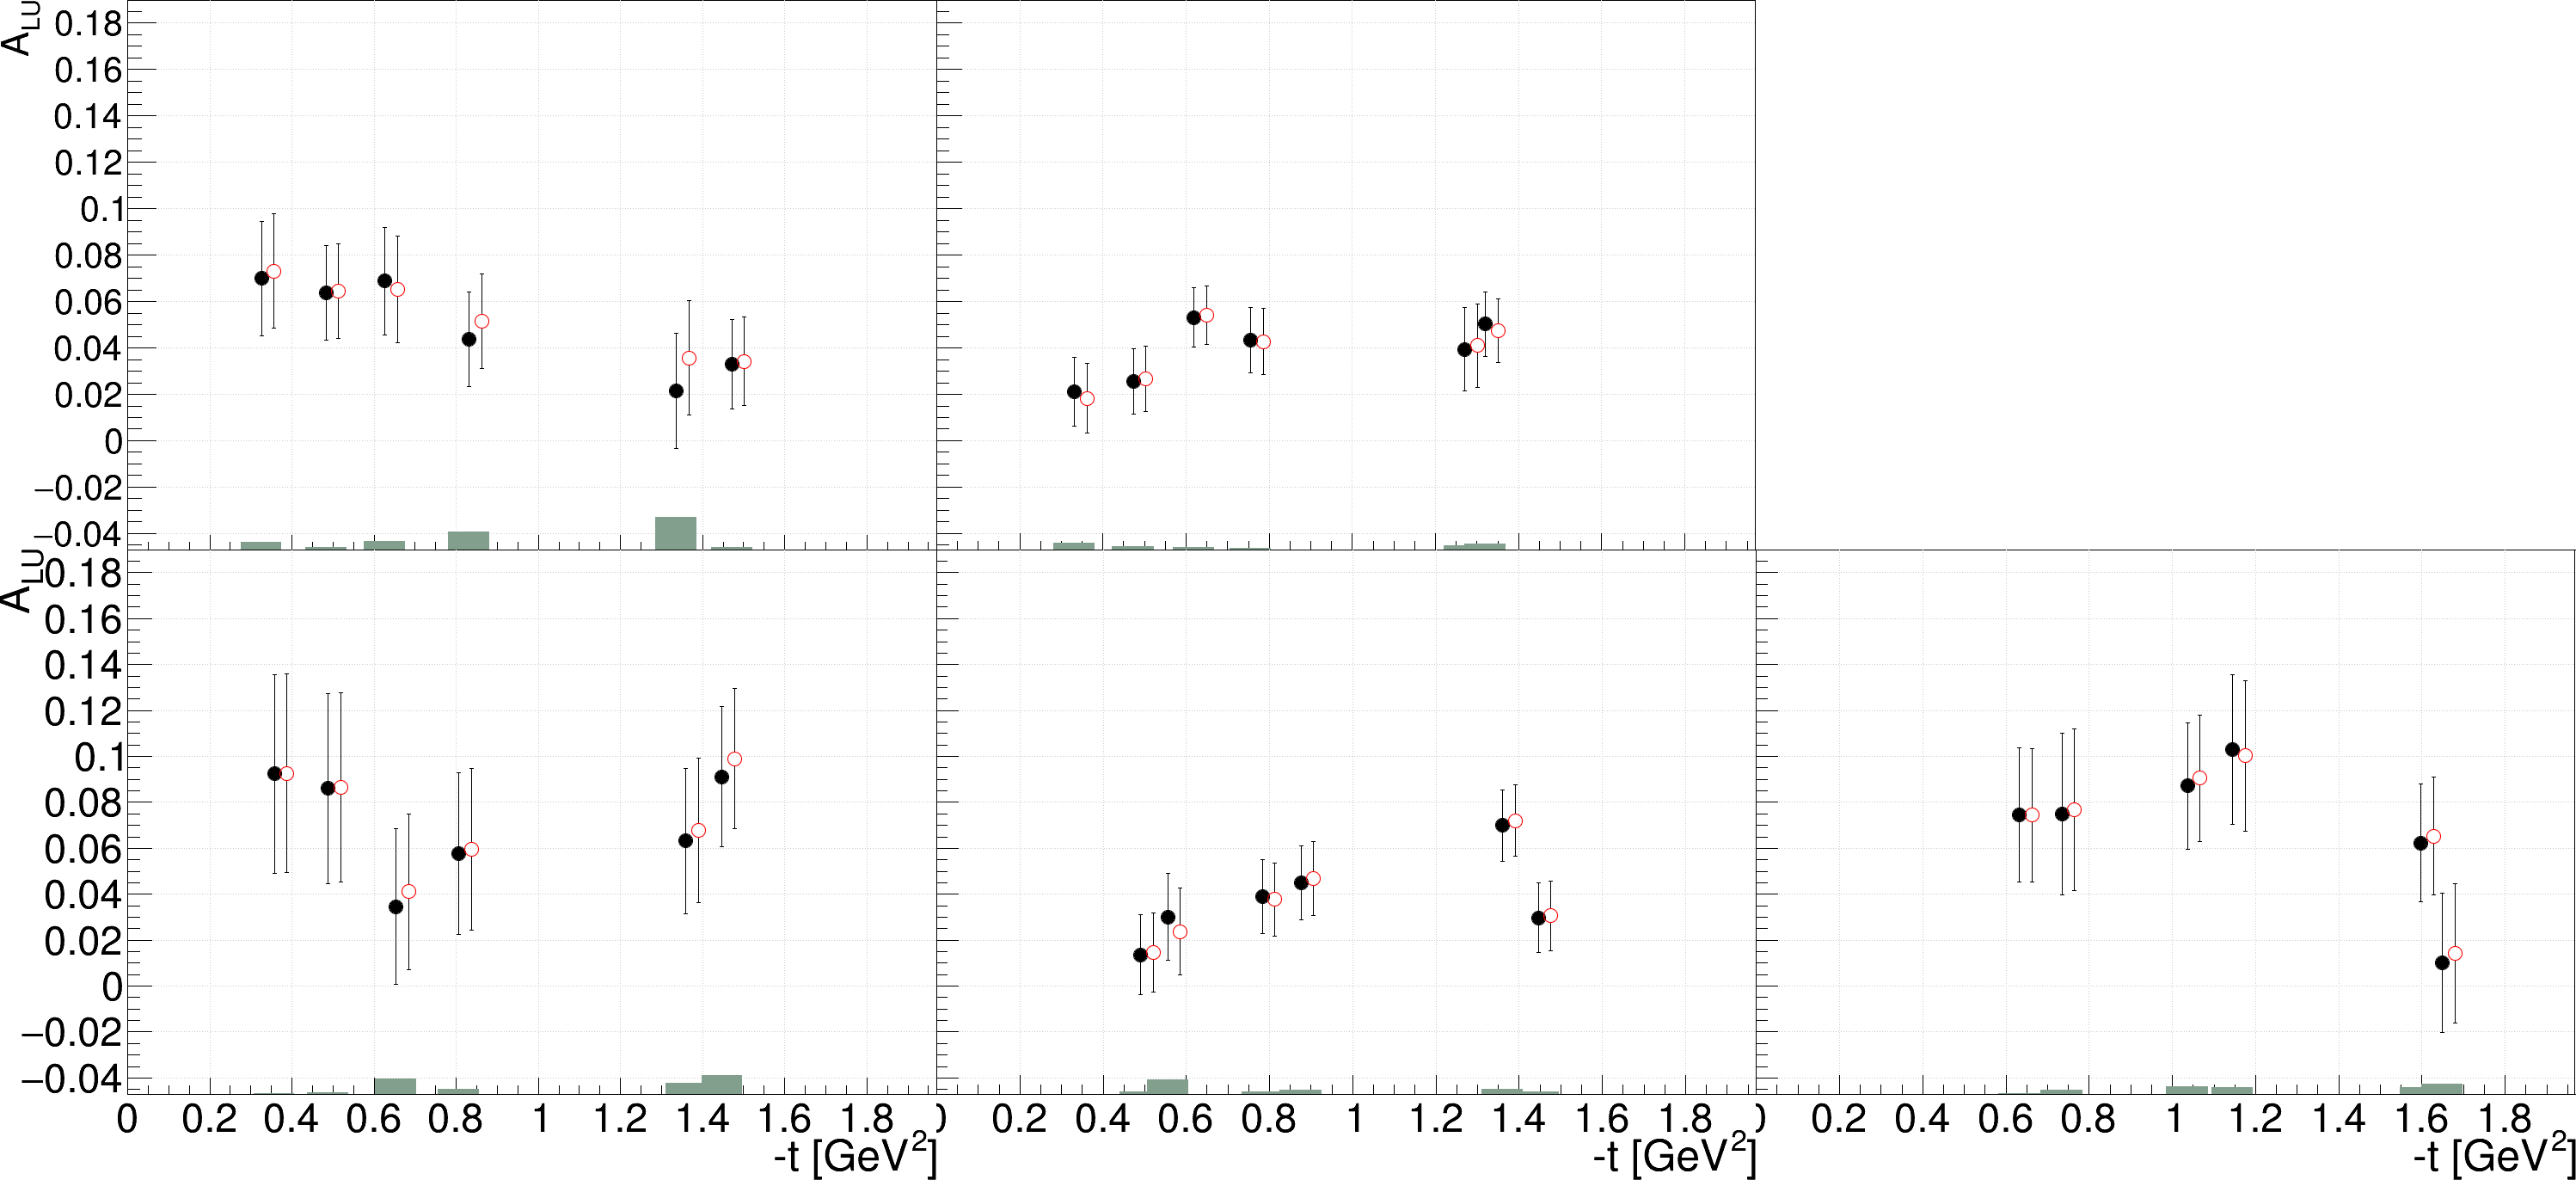

In [22]:
ROOT.gStyle.SetTitleOffset(0.96, 'Y')
ROOT.gStyle.SetPadLeftMargin(0.12)

httdfid = ROOT.TH1F("httfid","fiducial cuts systematics;#Delta_{syst}",200,0,0.052)

adf0,adf1,adf2,bdf0,bdf1,bdf2 = rdfs

c1 = ROOT.TCanvas("c1","c1",3000,1400)
c1.Draw()
c1.SetTopMargin(0)
c1.SetRightMargin(0)
c1.Divide(3,2,0,0)

grs = []

ipad=0
for aqdf in adf0.qdfs:
    bid = aqdf.binid

    ipad += 2 if ipad==2 else 1
    if ipad==2: c1.cd(ipad).SetRightMargin(0.001)

    h1 = c1.cd(ipad).DrawFrame(0,-0.047,1.97,0.19)
    h1.SetTitle(";-t [GeV^{2}];A_{LU}");

    grsys = ROOT.TGraphErrors()
    agr0,agr1,agr2,bgr0,bgr1,bgr2 = [df.shards[bid].grp1.Clone() for df in rdfs]
    gra,grb = agr0, bgr0
    graX,grbX = xshift(agr1, 0.03), xshift(bgr1, 0.03)
    
    for i in range(3):
        httdfid.Fill(abs(gra.GetPointY(i)-graX.GetPointY(i)))
        httdfid.Fill(abs(grb.GetPointY(i)-grbX.GetPointY(i)))
        grsys.SetPoint(grsys.GetN(), gra.GetPointX(i), -0.047)
        grsys.SetPointError(grsys.GetN()-1, 0.05, abs(gra.GetPointY(i)-graX.GetPointY(i)))
        grsys.SetPoint(grsys.GetN(), grb.GetPointX(i), -0.047)
        grsys.SetPointError(grsys.GetN()-1, 0.05, abs(grb.GetPointY(i)-grbX.GetPointY(i)))

    gra.Draw("P")
    grb.Draw("P")

    graX.Draw("P")
    grbX.Draw("P")

    gra.SetMarkerStyle(20)
    grb.SetMarkerStyle(20)
    graX.SetMarkerStyle(24)
    grbX.SetMarkerStyle(24)
    graX.SetMarkerColor(2)
    grbX.SetMarkerColor(2)
    
    grsys.SetFillColor(32)
    grsys.Draw("2")
    grs.append(grsys)


________________________________

### $dpt<0.3$ vs $|dpxy|<0.3$

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


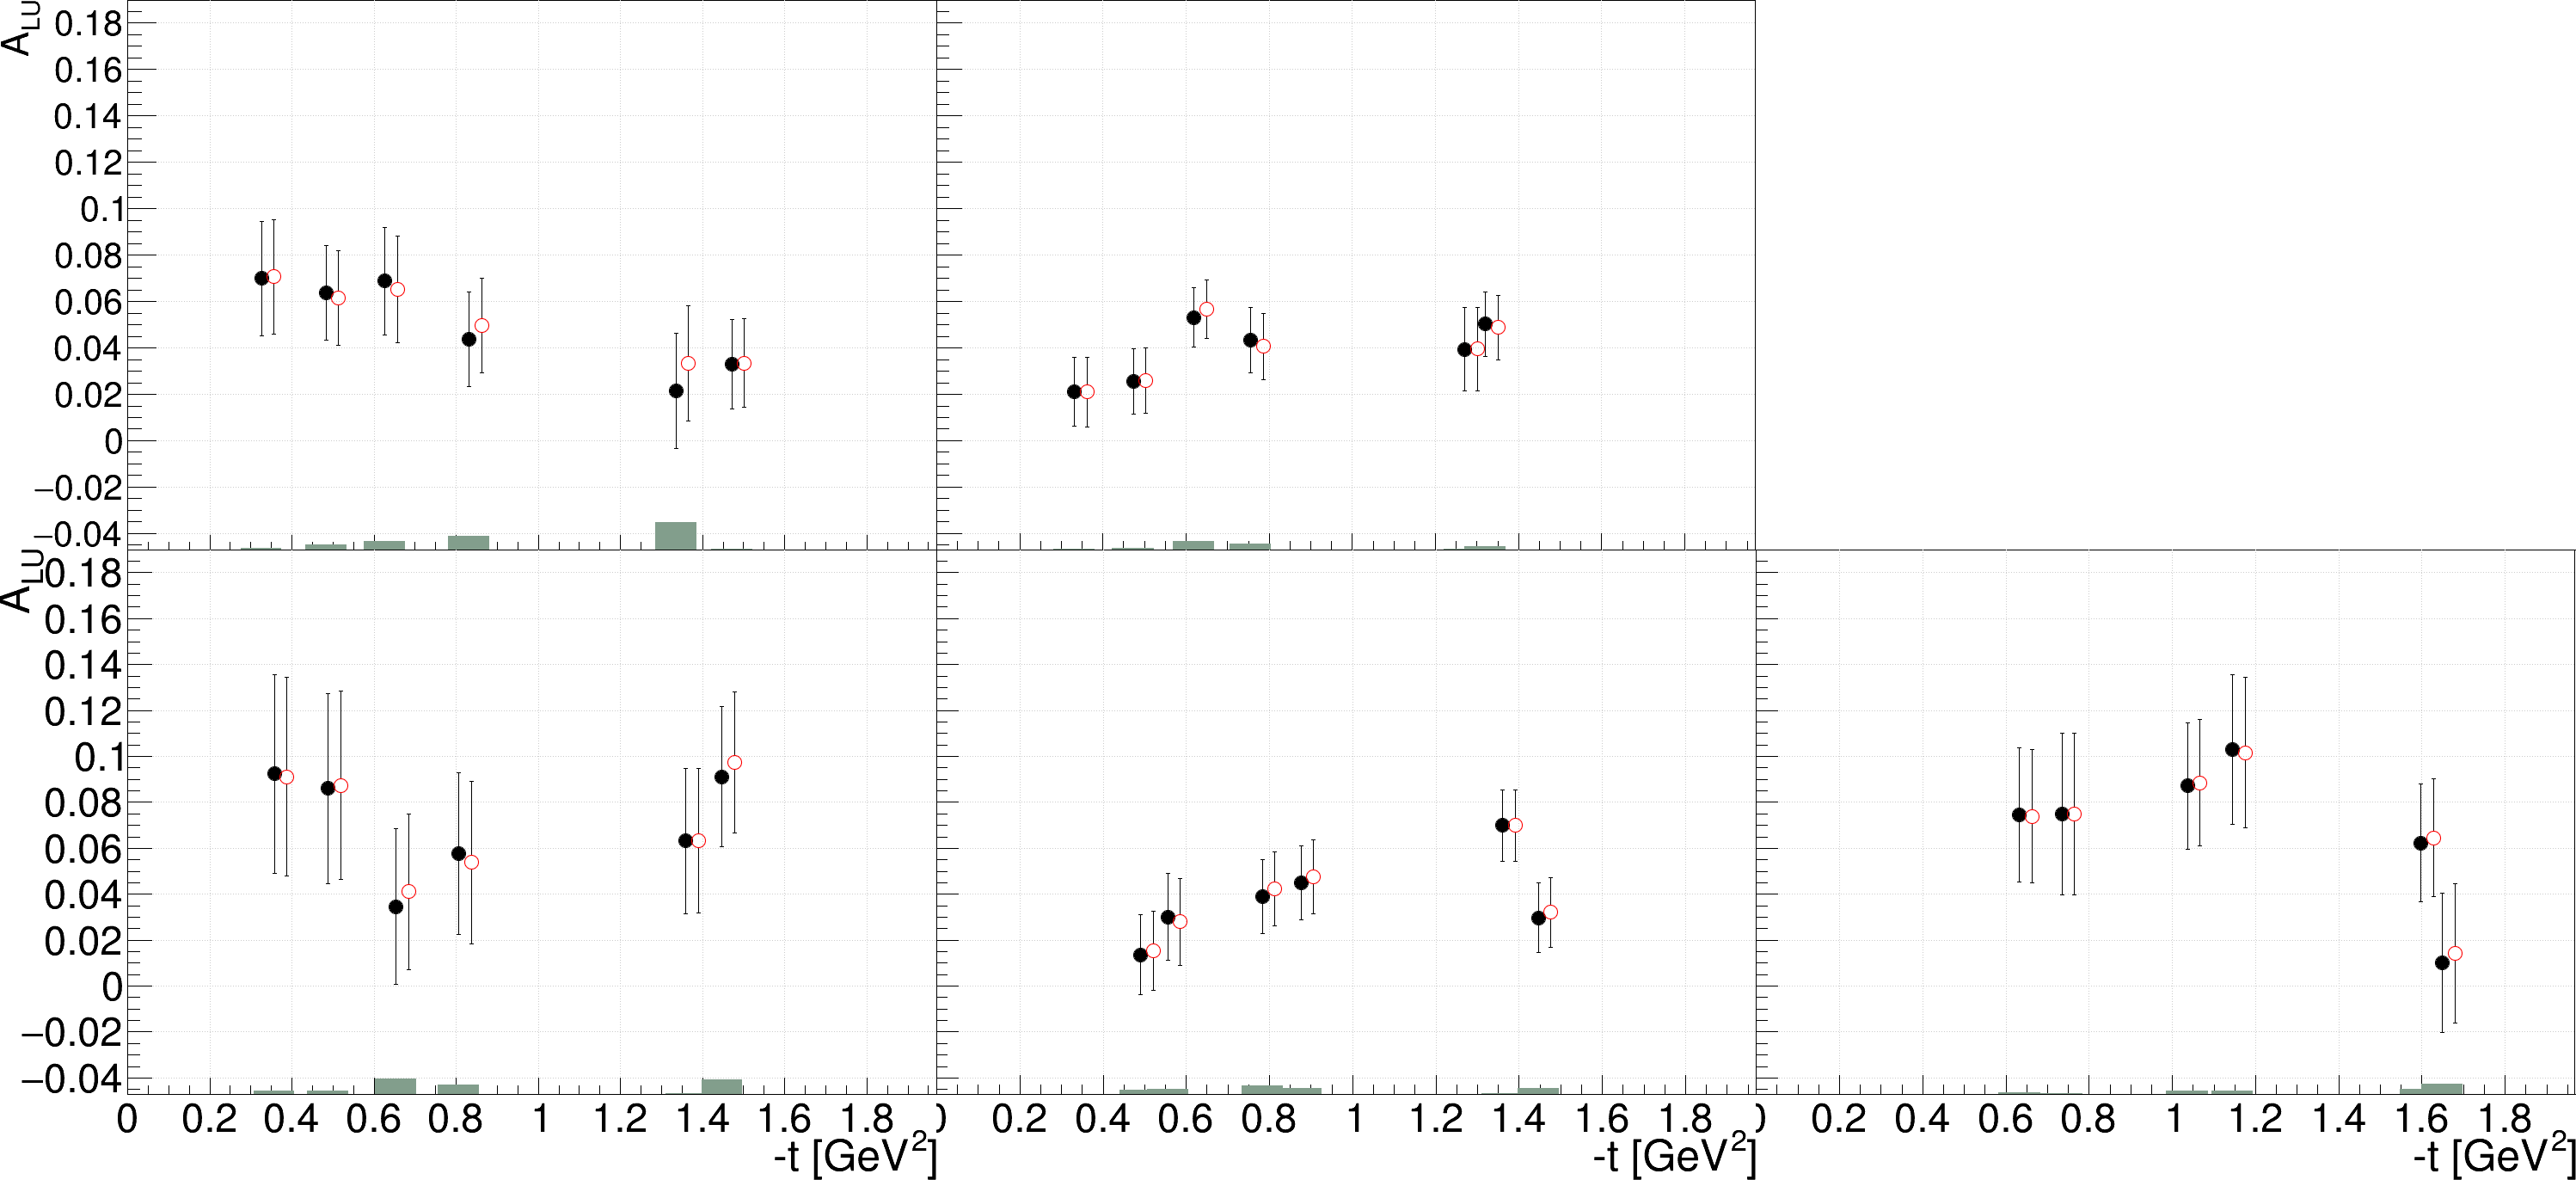

In [21]:
ROOT.gStyle.SetTitleOffset(0.96, 'Y')
ROOT.gStyle.SetPadLeftMargin(0.12)

httdfid = ROOT.TH1F("httfid","fiducial cuts systematics;#Delta_{syst}",200,0,0.052)

adf0,adf1,adf2,bdf0,bdf1,bdf2 = rdfs

c1 = ROOT.TCanvas("c1","c1",3000,1400)
c1.Draw()
c1.SetTopMargin(0)
c1.SetRightMargin(0)
c1.Divide(3,2,0,0)

grs = []

ipad=0
for aqdf in adf0.qdfs:
    bid = aqdf.binid

    ipad += 2 if ipad==2 else 1
    if ipad==2: c1.cd(ipad).SetRightMargin(0.001)

    h1 = c1.cd(ipad).DrawFrame(0,-0.047,1.97,0.19)
    h1.SetTitle(";-t [GeV^{2}];A_{LU}");

    grsys = ROOT.TGraphErrors()
    agr0,agr1,agr2,bgr0,bgr1,bgr2 = [df.shards[bid].grp1.Clone() for df in rdfs]
    gra,grb = agr0, bgr0
    graX,grbX = xshift(agr2, 0.03), xshift(bgr2, 0.03)
    
    for i in range(3):
        httdfid.Fill(abs(gra.GetPointY(i)-graX.GetPointY(i)))
        httdfid.Fill(abs(grb.GetPointY(i)-grbX.GetPointY(i)))
        grsys.SetPoint(grsys.GetN(), gra.GetPointX(i), -0.047)
        grsys.SetPointError(grsys.GetN()-1, 0.05, abs(gra.GetPointY(i)-graX.GetPointY(i)))
        grsys.SetPoint(grsys.GetN(), grb.GetPointX(i), -0.047)
        grsys.SetPointError(grsys.GetN()-1, 0.05, abs(grb.GetPointY(i)-grbX.GetPointY(i)))

    gra.Draw("P")
    grb.Draw("P")

    graX.Draw("P")
    grbX.Draw("P")

    gra.SetMarkerStyle(20)
    grb.SetMarkerStyle(20)
    graX.SetMarkerStyle(24)
    grbX.SetMarkerStyle(24)
    graX.SetMarkerColor(2)
    grbX.SetMarkerColor(2)
    
    grsys.SetFillColor(32)
    grsys.Draw("2")
    grs.append(grsys)


________________________________

### $dpt<0.424$ vs $|dpxy|<0.3$

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


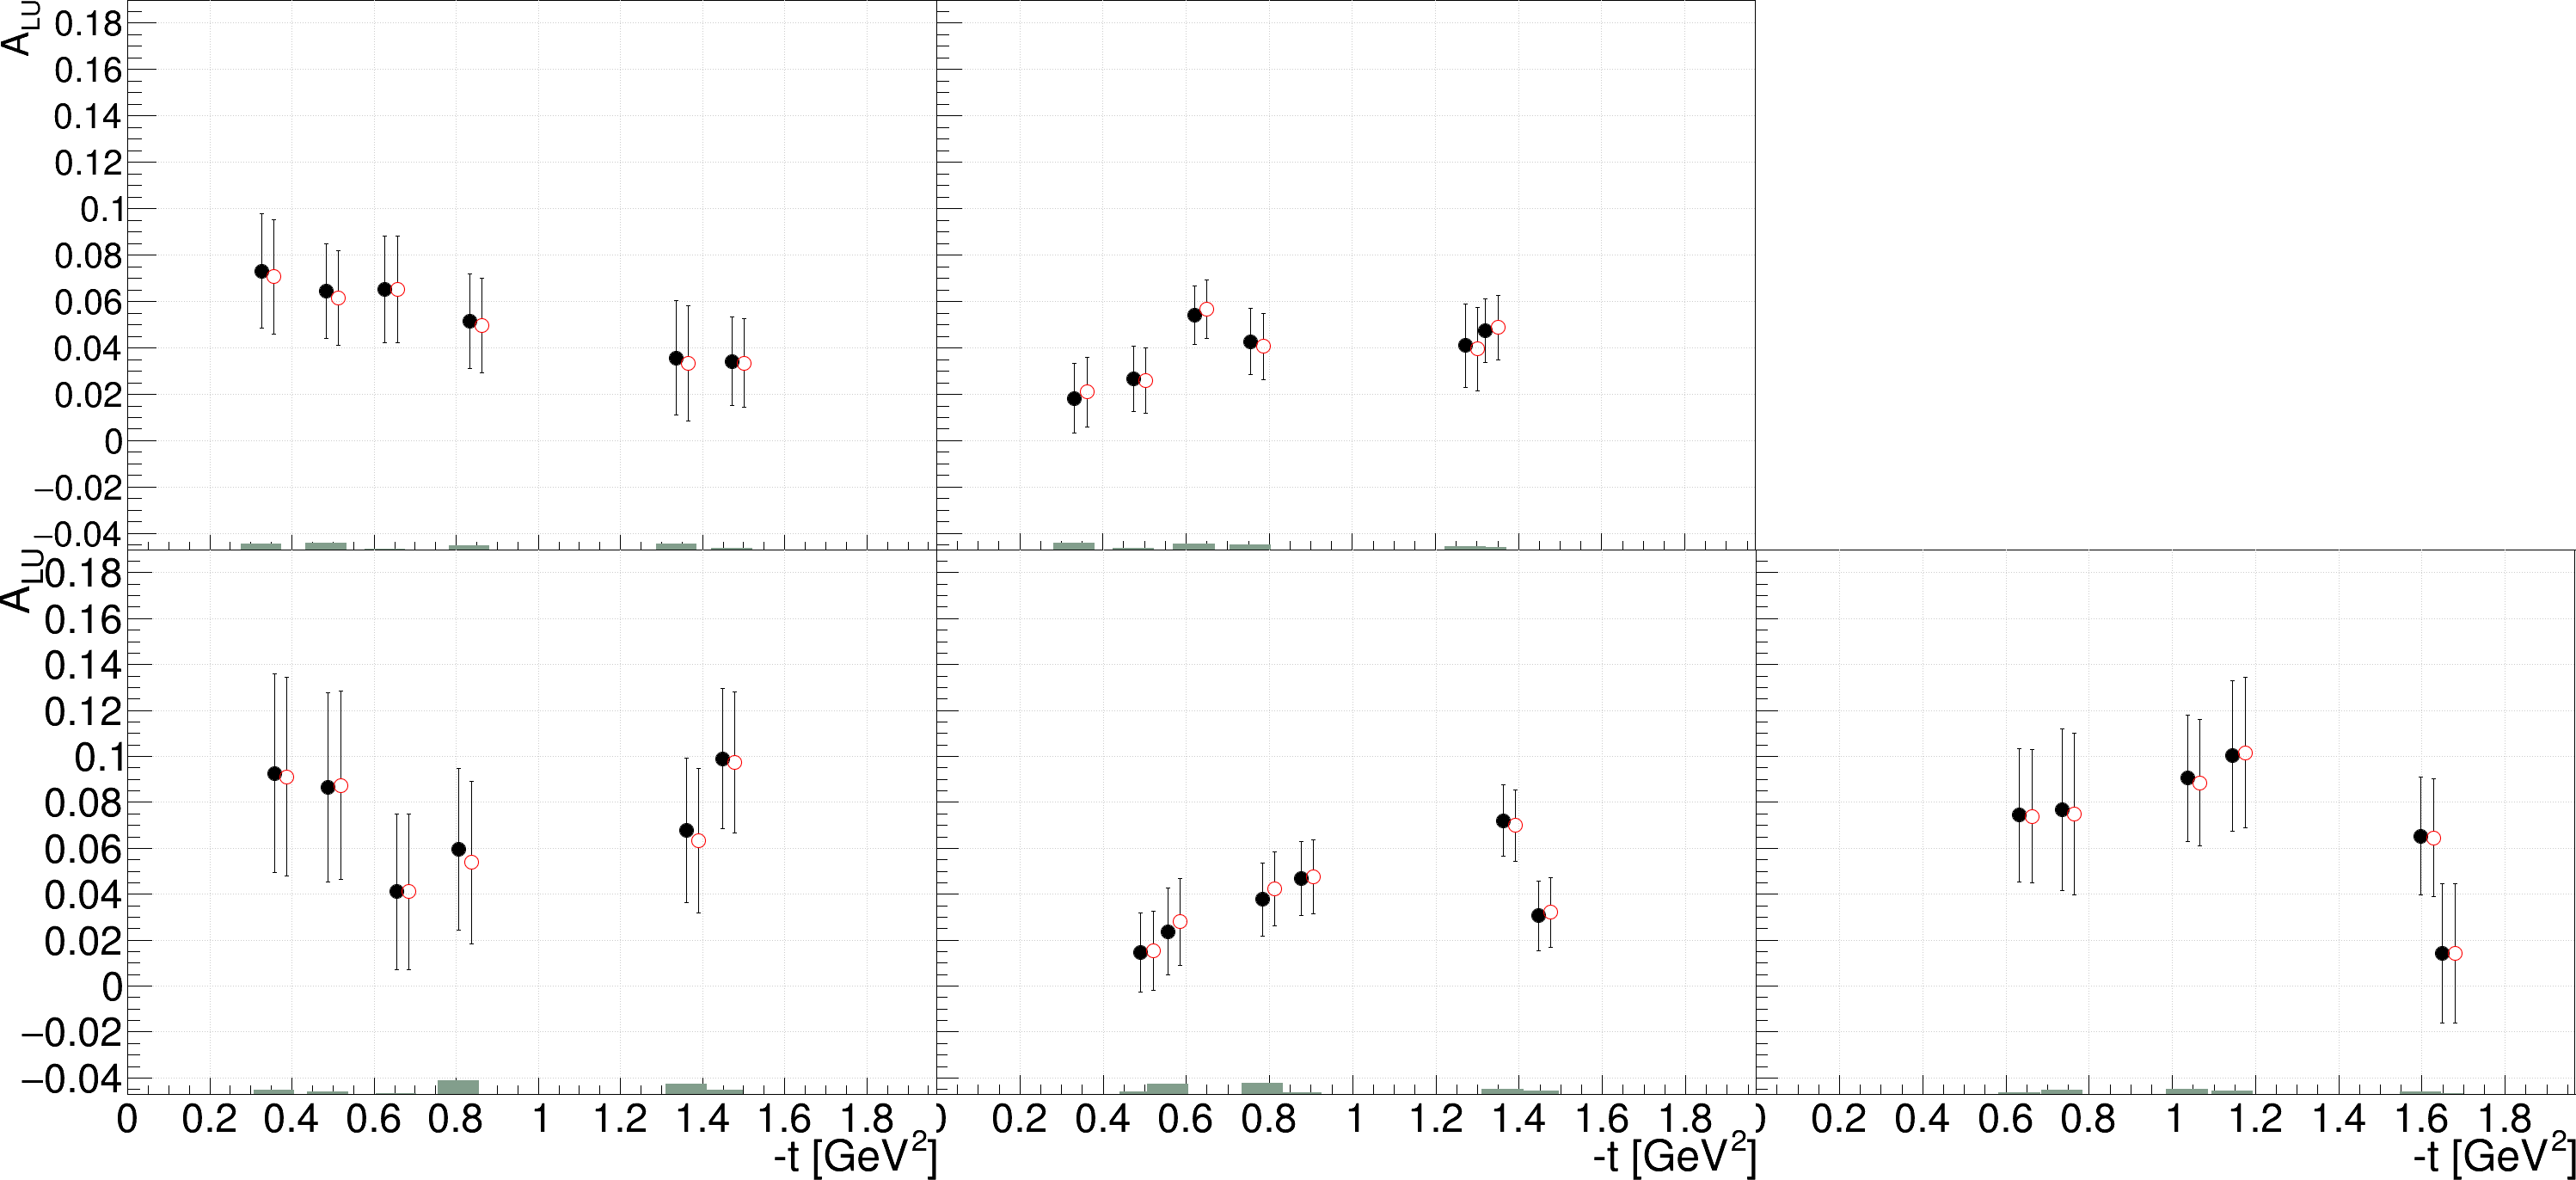

In [23]:
ROOT.gStyle.SetTitleOffset(0.96, 'Y')
ROOT.gStyle.SetPadLeftMargin(0.12)

httdfid = ROOT.TH1F("httfid","fiducial cuts systematics;#Delta_{syst}",200,0,0.052)

adf0,adf1,adf2,bdf0,bdf1,bdf2 = rdfs

c1 = ROOT.TCanvas("c1","c1",3000,1400)
c1.Draw()
c1.SetTopMargin(0)
c1.SetRightMargin(0)
c1.Divide(3,2,0,0)

grs = []

ipad=0
for aqdf in adf0.qdfs:
    bid = aqdf.binid

    ipad += 2 if ipad==2 else 1
    if ipad==2: c1.cd(ipad).SetRightMargin(0.001)

    h1 = c1.cd(ipad).DrawFrame(0,-0.047,1.97,0.19)
    h1.SetTitle(";-t [GeV^{2}];A_{LU}");

    grsys = ROOT.TGraphErrors()
    agr0,agr1,agr2,bgr0,bgr1,bgr2 = [df.shards[bid].grp1.Clone() for df in rdfs]
    gra,grb = agr1, bgr1
    graX,grbX = xshift(agr2, 0.03), xshift(bgr2, 0.03)
    
    for i in range(3):
        httdfid.Fill(abs(gra.GetPointY(i)-graX.GetPointY(i)))
        httdfid.Fill(abs(grb.GetPointY(i)-grbX.GetPointY(i)))
        grsys.SetPoint(grsys.GetN(), gra.GetPointX(i), -0.047)
        grsys.SetPointError(grsys.GetN()-1, 0.05, abs(gra.GetPointY(i)-graX.GetPointY(i)))
        grsys.SetPoint(grsys.GetN(), grb.GetPointX(i), -0.047)
        grsys.SetPointError(grsys.GetN()-1, 0.05, abs(grb.GetPointY(i)-grbX.GetPointY(i)))

    gra.Draw("P")
    grb.Draw("P")

    graX.Draw("P")
    grbX.Draw("P")

    gra.SetMarkerStyle(20)
    grb.SetMarkerStyle(20)
    graX.SetMarkerStyle(24)
    grbX.SetMarkerStyle(24)
    graX.SetMarkerColor(2)
    grbX.SetMarkerColor(2)
    
    grsys.SetFillColor(32)
    grsys.Draw("2")
    grs.append(grsys)


________________________________

## 1D distributions

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


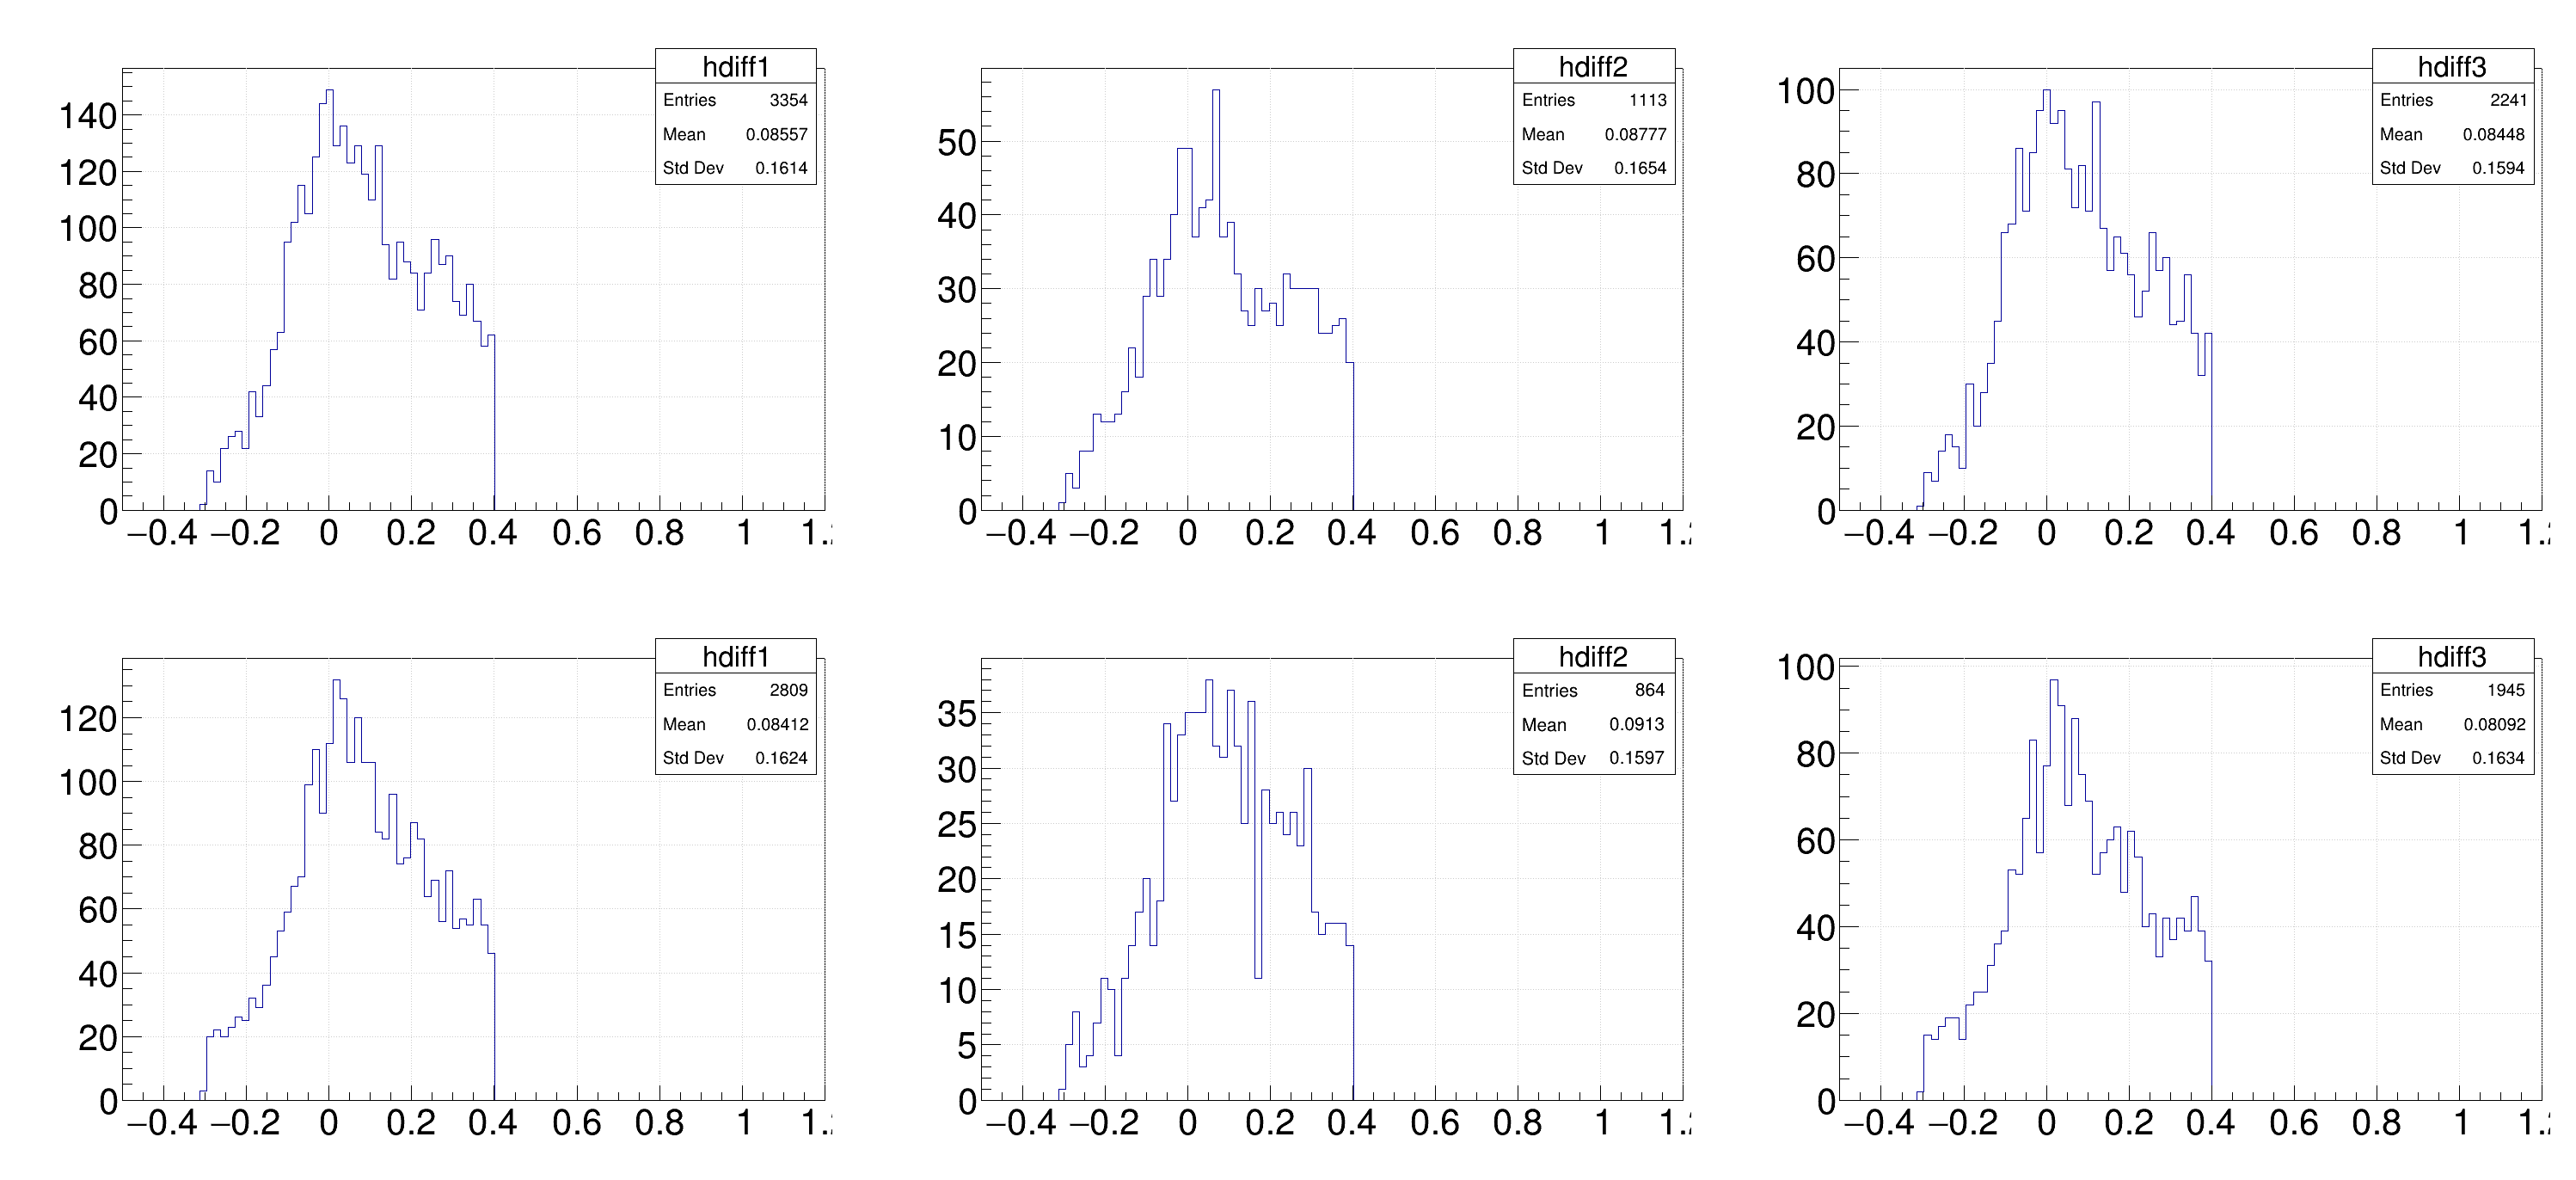

In [32]:
c1 = ROOT.TCanvas("c1","c1",3000,1400)
c1.Divide(3,2)
c1.Draw()

ROOT.gStyle.SetOptStat(1)

adf0,adf1,adf2,bdf0,bdf1,bdf2 = rdfs

ipad,h1s = 0,[]
for df in [adf1, bdf1]:
    h1 = df.Filter("abs(dpt)>0.3 && abs(dpt)<0.424").Histo1D(("hdiff1","",100,-0.5,1.2), "mm2")
    h2 = df.Filter("(dpx>0.3 || dpy>0.3) && abs(dpt)<0.424").Histo1D(("hdiff2","",100,-0.5,1.2), "mm2")
    h3 = df.Filter("(dpx<0.3 && dpy<0.3) && abs(dpt)>0.3").Histo1D(("hdiff3","",100,-0.5,1.2), "mm2")
    
    h1s.append([h1,h2,h3])
    for hh in h1s[-1]:
        ipad+=1
        c1.cd(ipad)
        hh.Draw()


________________________________

________________________________

________________________________